# Data Science Salaries 2022-2023 EDA

## Description of the data set / summary of its attributes: 

`work_year`: The year the salary was paid.
`experience_level`: The experience level in the job during the year
`employment_type`: The type of employment for the role
`job_title`: The role worked in during the year.
`salary`: The total gross salary amount paid.
`salary_currency`: The currency of the salary paid as an ISO 4217 currency code.
`salaryinusd`: The salary in USD
`employee_residence`: Employee's primary country of residence in during the work year as an ISO 3166 country code.
`remote_ratio`: The overall amount of work done remotely
`company_location`: The country of the employer's main office or contracting branch
`company_size`: The median number of people that worked for the company during the year

In [93]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 
%matplotlib inline

In [94]:
df = pd.read_csv("datascience_salaries.csv")

In [95]:
df.shape

(3755, 11)

## Plan for Data Exploration: 

##### Look for the information of the DataSet and the datatypes of its features. 
##### Determine whether the DataSet has NA values, and if so fill them with the necessary values (mean, median, 0, previous value, etc). 
##### Filter/Delete the columns that don’t seem necessary for the analysis. 
##### Look for outliers with visualization tools (boxplot) and statistic methods (z-score). 
##### Create visualizations (seaborn and plotly.express)

## Actions taken for data cleaning and feature engineering: 

##### Some column names renamed to be more informative. 
##### Some records’ data replaced with more informative categorical values ("employment_type", "experience_level", and "work_setting" values). 
##### Dropped records where the year wasn’t 2022 or 2023. 
##### Enforced one-hot encoding in some columns' variables with get_dummies() to be later fitted with the Standard Scaler method of scikit-learn. 
##### Checked the skewness level for the continuous variable target (salary). 
##### Determined log transformation or any transformation would be necessary based on the score (skew = 0.5080). 
##### Did PCA() on the predictor features of the dataset already encoded with a 95% of n_components. 

In [96]:
df.rename(columns={"remote_ratio":"work_setting"},inplace=True)

In [97]:
df.replace({"FT":"Full-Time","PT":"Part-Time","CT":"Casual/Temporary","FL":"Freelance"},inplace=True)
df.replace({"SE":"Senior","MI":"Mid-Level","EN":"Entry-Level","EX":"Expert"},inplace=True)
df.replace({0:"Presential",50:"Hybrid",100:"Remote"},inplace=True)

In [98]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,work_setting,company_location,company_size
0,2023,Senior,Full-Time,Principal Data Scientist,80000,EUR,85847,ES,Remote,ES,L
1,2023,Mid-Level,Casual/Temporary,ML Engineer,30000,USD,30000,US,Remote,US,S
2,2023,Mid-Level,Casual/Temporary,ML Engineer,25500,USD,25500,US,Remote,US,S
3,2023,Senior,Full-Time,Data Scientist,175000,USD,175000,CA,Remote,CA,M
4,2023,Senior,Full-Time,Data Scientist,120000,USD,120000,CA,Remote,CA,M


In [99]:
years_to_drop = [2022, 2023]
df = df[df.work_year.isin(years_to_drop)].reset_index().drop("index",axis=1)

In [100]:
df_encode_cols = df.dtypes[df.dtypes == object].index.tolist()
df_encode_cols

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'work_setting',
 'company_location',
 'company_size']

In [101]:
salary_usd_stats = df.salary_in_usd.describe()
display(salary_usd_stats)

count      3449.000000
mean     141467.601044
std       60681.562650
min        5132.000000
25%      100000.000000
50%      138750.000000
75%      180000.000000
max      430967.000000
Name: salary_in_usd, dtype: float64

<Axes: xlabel='salary_in_usd', ylabel='Count'>

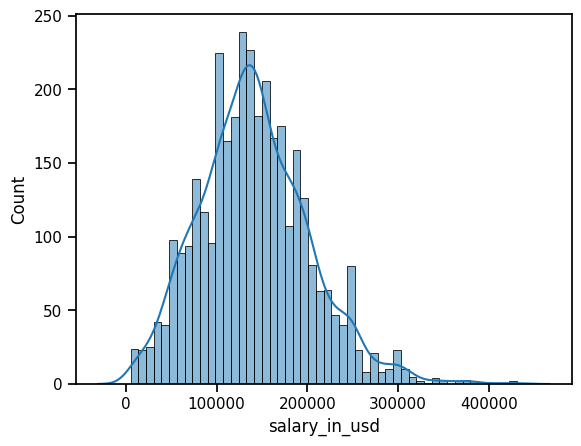

In [102]:
sns.histplot(df.salary_in_usd, kde=True, kde_kws={"cut":3}, alpha = 0.5, bins=50)

In [103]:
salary_usd_skew = df.salary_in_usd.skew()
display(salary_usd_skew)

0.5080703800945726

In [104]:
pairplot_columns = df[['experience_level', 'employment_type', 'job_title',
       'salary_currency', 'salary_in_usd', 'employee_residence',
       'work_setting', 'company_location', 'company_size']]
# display(pairplot_columns)

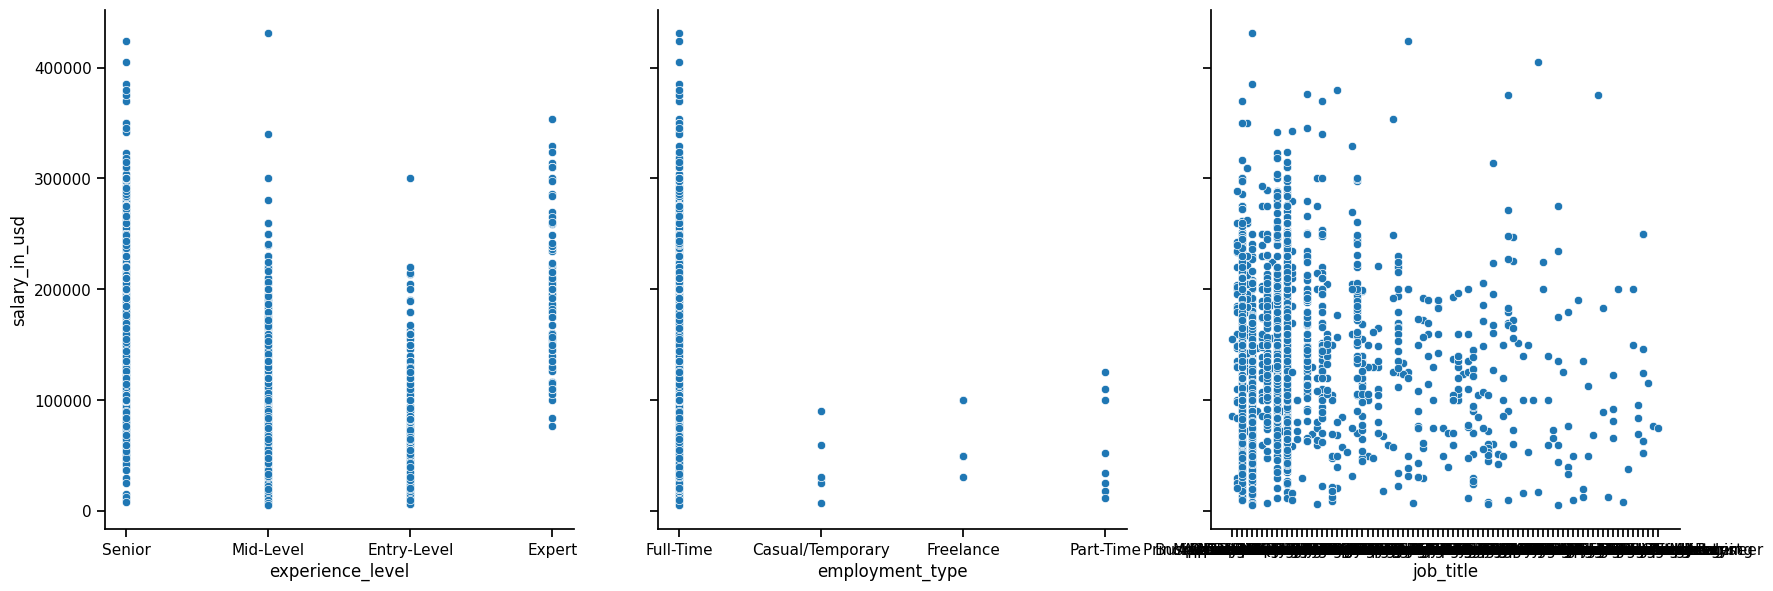

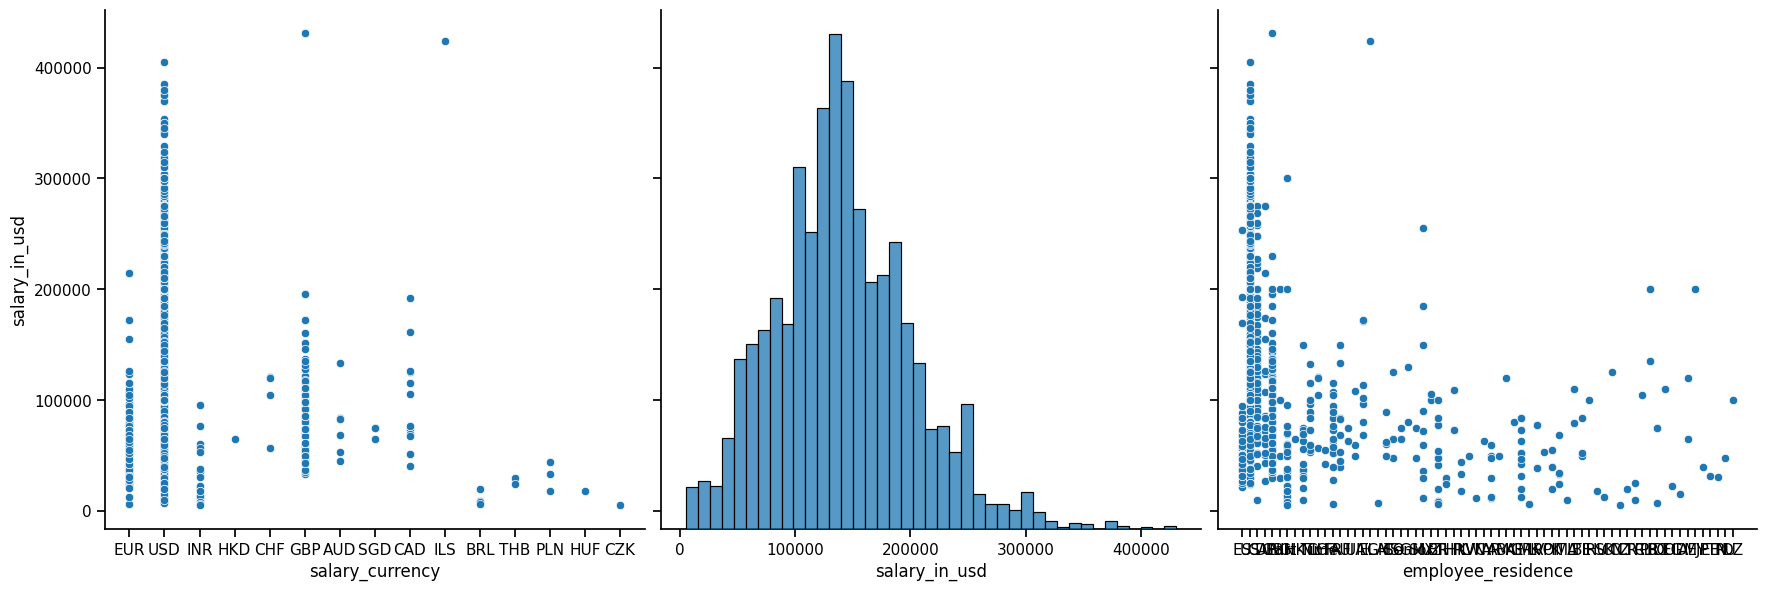

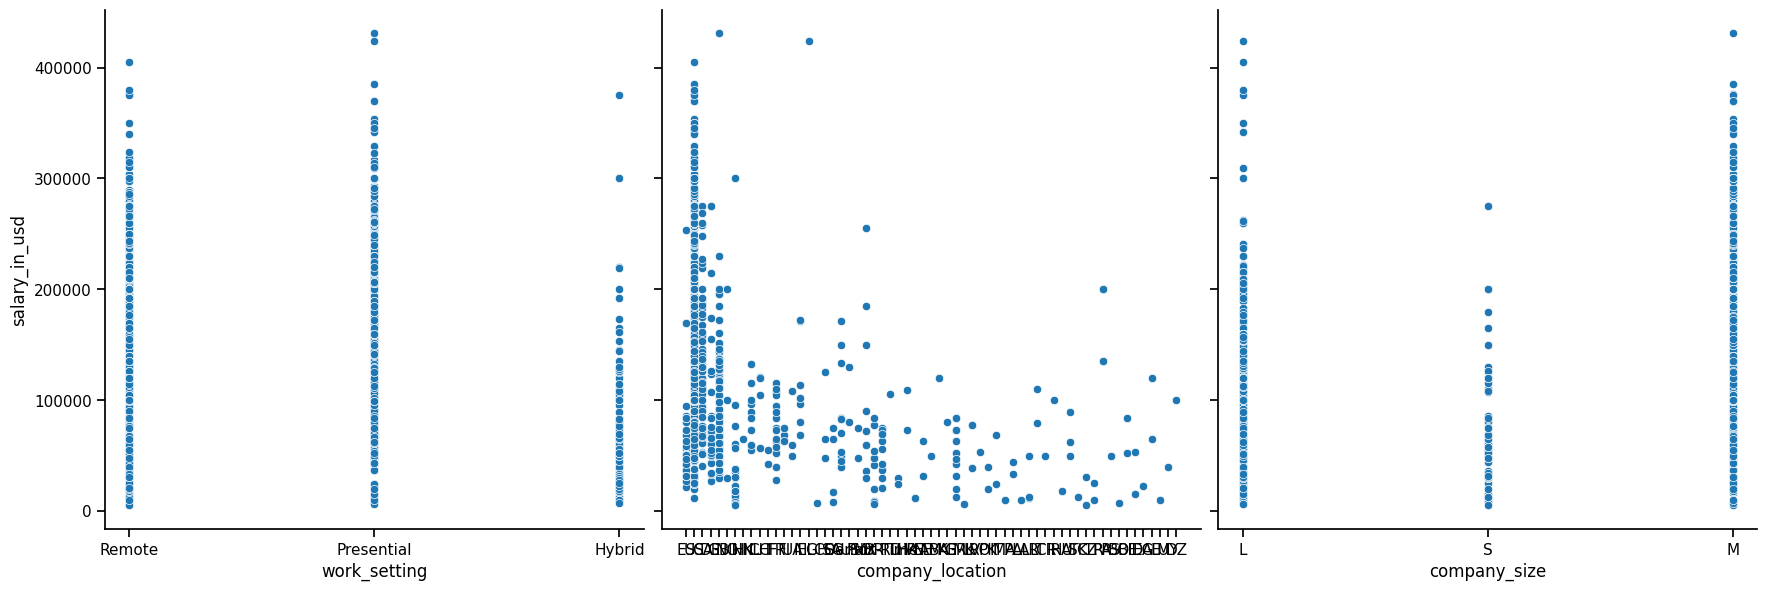

In [105]:
sns.set_context("notebook")
for i in range(0, len(pairplot_columns.columns), 3):
    sns.pairplot(data=pairplot_columns, x_vars=pairplot_columns.columns[i:i+3], y_vars=['salary_in_usd'], height=6)

In [106]:
corr_data = df.dtypes == object
# display(pairplot_data)
corr_columns = df.columns[corr_data]
# display(corr_columns)
corr_df = pd.get_dummies(data=df, drop_first=True, columns=['experience_level', 'employment_type', 'job_title', 'employee_residence', 'work_setting', 'company_location','company_size'])
# corr_df.head()
corr_data = corr_df.dtypes != object
# display(corr_data)
corr_columns = corr_df.columns[corr_data]
# display(corr_df)
corr_df = corr_df.loc[:,corr_columns]
# pairplot_df.head()

<Axes: >

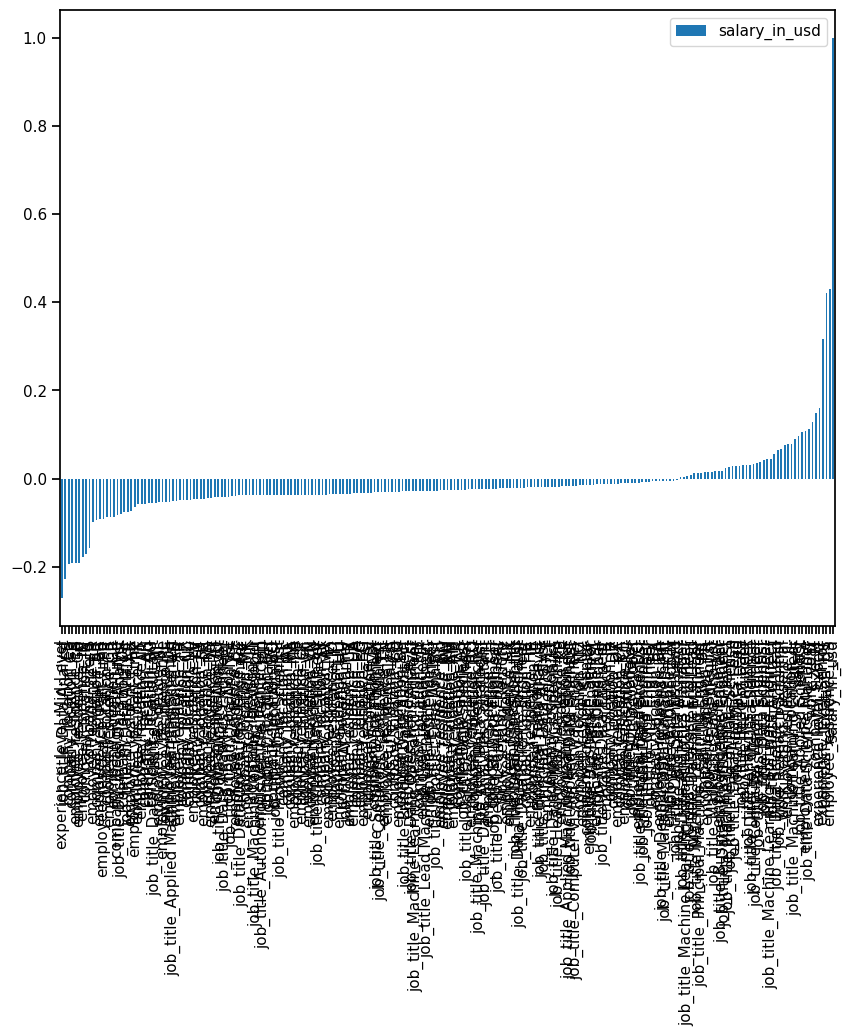

In [107]:
corr_features = corr_df.corr()['salary_in_usd'].sort_values().to_frame()
corr_features.plot(kind='bar',figsize=(10,8))

In [108]:
corr_features[corr_features.salary_in_usd >= abs(0.4)]

,salary_in_usd
company_location_US,0.422061
employee_residence_US,0.430587
salary_in_usd,1.000000


In [109]:
corr_df_ints = corr_df.astype(int)
corr_df_ints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3449 entries, 0 to 3448
Columns: 223 entries, work_year to company_size_S
dtypes: int32(223)
memory usage: 2.9 MB


In [110]:
corr_df_ints.head()

,work_year,salary,salary_in_usd,experience_level_Expert,experience_level_Mid-Level,experience_level_Senior,employment_type_Freelance,employment_type_Full-Time,employment_type_Part-Time,job_title_AI Developer,...,company_location_SI,company_location_SK,company_location_Senior,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_M,company_size_S
0,2023,80000,85847,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023,30000,30000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2023,25500,25500,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,2023,175000,175000,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2023,120000,120000,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [111]:
x_data = ~corr_df_ints.columns.isin(["salary_in_usd", "work_year"])
x_data = corr_df_ints.loc[:,x_data]
# print(x_data.shape)
display(x_data.head())
y_data = corr_df_ints.columns == "salary_in_usd"
y_data = corr_df_ints.loc[:,y_data]
# print(y_data.shape)
display(y_data.head())

,salary,experience_level_Expert,experience_level_Mid-Level,experience_level_Senior,employment_type_Freelance,employment_type_Full-Time,employment_type_Part-Time,job_title_AI Developer,job_title_AI Programmer,job_title_AI Scientist,...,company_location_SI,company_location_SK,company_location_Senior,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_M,company_size_S
0,80000,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,25500,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,175000,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,120000,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


,salary_in_usd
0,85847
1,30000
2,25500
3,175000
4,120000


In [112]:
scaler = StandardScaler()
x_data=scaler.fit_transform(x_data.astype(np.float64))
x_data

array([[-0.30083364, -0.17368726, -0.49601009, ..., -0.01703007,
        -2.89348969, -0.1501062 ],
       [-0.48246827, -0.17368726,  2.01608801, ..., -0.01703007,
        -2.89348969,  6.66195009],
       [-0.49881539, -0.17368726,  2.01608801, ..., -0.01703007,
        -2.89348969,  6.66195009],
       ...,
       [-0.30083364, -0.17368726, -0.49601009, ..., -0.01703007,
         0.34560344, -0.1501062 ],
       [-0.13736246, -0.17368726, -0.49601009, ..., -0.01703007,
         0.34560344, -0.1501062 ],
       [-0.5187952 , -0.17368726, -0.49601009, ..., -0.01703007,
        -2.89348969, -0.1501062 ]])

In [113]:
pca = PCA(n_components=0.95)
x_data_reduced = pca.fit_transform(x_data)

In [114]:
x_data_reduced.shape

(3449, 143)

In [115]:
df.job_title.value_counts(ascending=False).to_frame().head(10)

,count
job_title,
Data Engineer,987
Data Scientist,775
Data Analyst,583
Machine Learning Engineer,267
Analytics Engineer,103
Data Architect,98
Research Scientist,70
Applied Scientist,58
Data Science Manager,51


In [116]:
pairplot_columns.salary_in_usd.describe().to_frame()

,salary_in_usd
count,3449.000000
mean,141467.601044
std,60681.562650
min,5132.000000
25%,100000.000000
50%,138750.000000
75%,180000.000000
max,430967.000000


<Axes: >

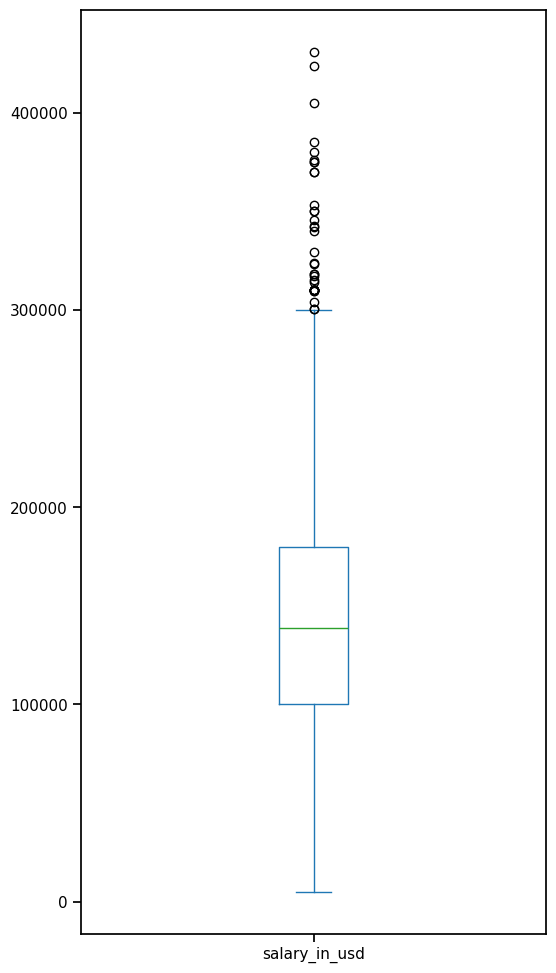

In [117]:
# sns.boxplot(data=pairplot_columns.salary_in_usd)
pairplot_columns.salary_in_usd.plot(kind='box',figsize=(6,12))

In [118]:
pairplot_columns["salary_usd_zscore"] = stats.zscore(pairplot_columns.salary_in_usd)
pairplot_columns[["salary_in_usd","salary_usd_zscore"]].describe().round(3)

C:\Users\Fernando\AppData\Local\Temp\ipykernel_32972\1656305098.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,salary_in_usd,salary_usd_zscore
count,3449.000,3449.000
mean,141467.601,0.000
std,60681.563,1.000
min,5132.000,-2.247
25%,100000.000,-0.683
50%,138750.000,-0.045
75%,180000.000,0.635
max,430967.000,4.771


In [119]:
pairplot_columns[pairplot_columns.salary_usd_zscore > 3].sort_values(by="salary_in_usd")

,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,work_setting,company_location,company_size,salary_usd_zscore
3385,Expert,Full-Time,Data Engineer,USD,324000,US,Remote,US,M,3.008473
227,Expert,Full-Time,Head of Data,USD,329500,US,Presential,US,M,3.099124
843,Mid-Level,Full-Time,Research Scientist,USD,340000,US,Remote,US,M,3.272183
133,Senior,Full-Time,Machine Learning Engineer,USD,342300,US,Presential,US,L,3.310091
33,Senior,Full-Time,Computer Vision Engineer,USD,342810,US,Presential,US,M,3.318497
2545,Senior,Full-Time,Data Architect,USD,345600,US,Presential,US,M,3.364482
1418,Senior,Full-Time,Applied Scientist,USD,350000,US,Presential,US,L,3.437002
2364,Senior,Full-Time,Data Scientist,USD,350000,US,Remote,US,M,3.437002
477,Expert,Full-Time,Director of Data Science,USD,353200,US,Presential,US,M,3.489744
1103,Senior,Full-Time,Data Scientist,USD,370000,US,Presential,US,M,3.766639


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85],
 [Text(0, 0, 'Principal Data Scientist'),
  Text(1, 0, 'ML Engineer'),
  Text(2, 0, 'Data Scientist'),
  Text(3, 0, 'Applied Scientist'),
  Text(4, 0, 'Data Analyst'),
  Text(5, 0, 'Data Modeler'),
  Text(6, 0, 'Research Engineer'),
  Text(7, 0, 'Analytics Engineer'),
  Text(8, 0, 'Business Intelligence Engineer'),
  Text(9, 0, 'Machine Learning Engineer'),
  Text(10, 0, 'Data Strategist'),
  Text(11, 0, 'Data Engineer'),
  Text(12, 0, 'Computer Vision Engineer'),
  Text(13, 0, 'Data Qual

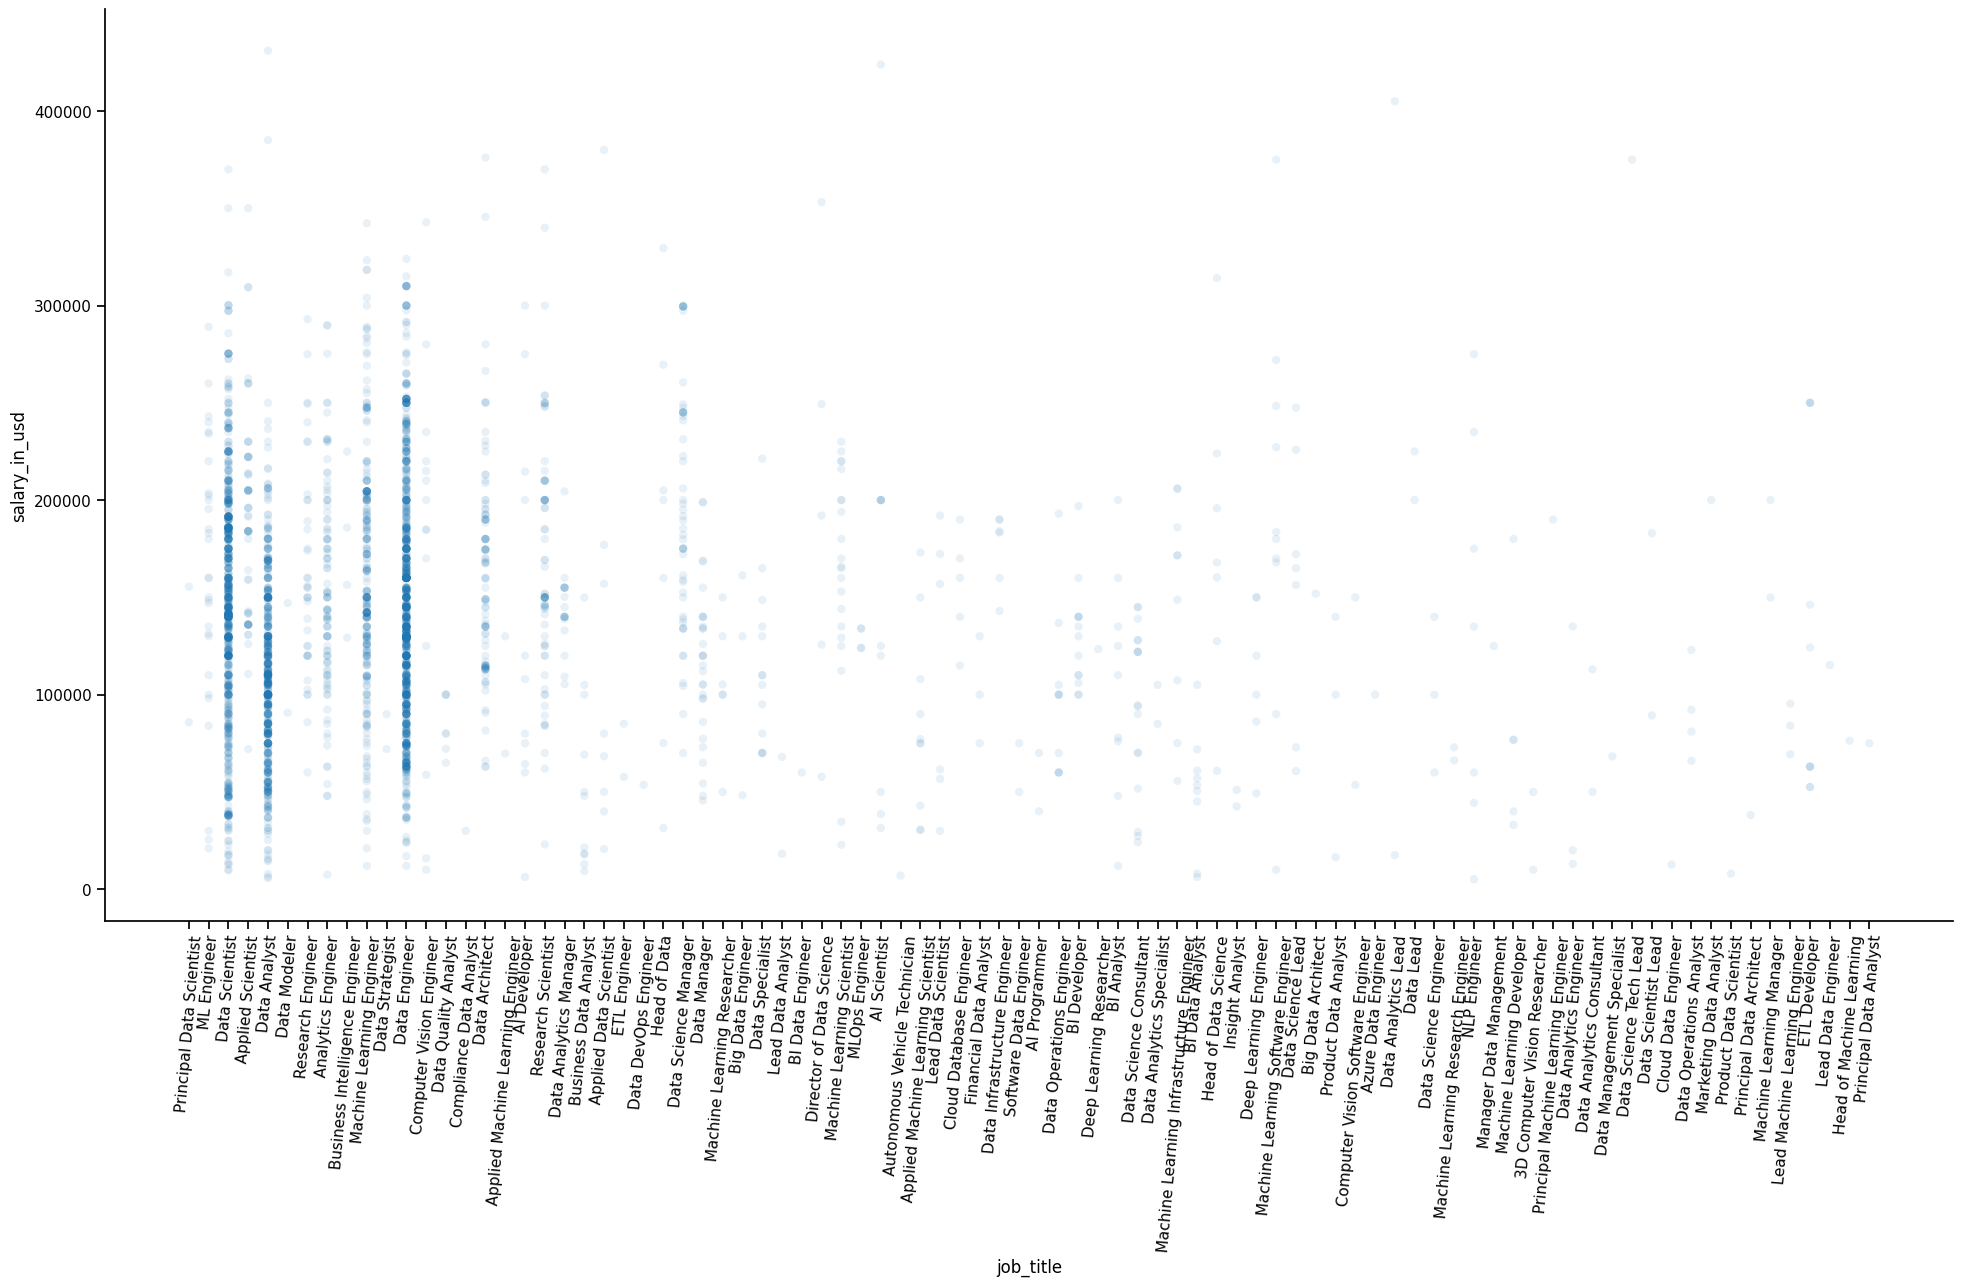

In [120]:
sns.set_context("notebook")
sns.pairplot(data=pairplot_columns, x_vars=['job_title'], y_vars=['salary_in_usd'], plot_kws={"edgecolor":"none","alpha":0.1}, height= 10, aspect=2)
plt.xticks(rotation=85)

In [121]:
by_work_setting = df.groupby(["work_year","work_setting"])["salary_in_usd"].mean().reset_index(name = "usd_salary").round(3)

In [122]:
by_work_setting

,work_year,work_setting,usd_salary
0,2022,Hybrid,84560.871
1,2022,Presential,134719.236
2,2022,Remote,135631.104
3,2023,Hybrid,72053.500
4,2023,Presential,152393.522
5,2023,Remote,146380.125


In [123]:
fig = px.bar(by_work_setting,  
            x='work_setting', y = "usd_salary", animation_frame="work_year")
fig.update_layout(
    title="Time Lapse of Average USD salary, by Work Setting",
    xaxis_title="Work Setting",
    yaxis_title="Average USD Salary")

fig.show()

In [124]:
hypothesis_df = df[df.experience_level.isin(["Expert","Senior","Mid-Level"])]
hypothesis_df.experience_level.value_counts()

experience_level
Senior       2425
Mid-Level     681
Expert        101
Name: count, dtype: int64

In [125]:
df.groupby([hypothesis_df.experience_level]).salary_in_usd.mean()

experience_level
Expert       197435.772277
Mid-Level    108350.296623
Senior       153980.179794
Name: salary_in_usd, dtype: float64

In [126]:
pairplot_columns.employment_type[pairplot_columns.employment_type == "Full-Time"].count()/pairplot_columns.employment_type.count()*100

99.42012177442737

In [127]:
pairplot_columns.work_setting.value_counts()/pairplot_columns.work_setting.count()*100

work_setting
Presential    54.305596
Remote        43.026964
Hybrid         2.667440
Name: count, dtype: float64

In [128]:
pairplot_columns.company_location.value_counts().head()

company_location
US    2909
GB     153
CA      74
ES      69
DE      33
Name: count, dtype: int64

In [129]:
pairplot_columns.salary_in_usd[pairplot_columns.experience_level == "Mid-Level"].describe()

count       681.000000
mean     108350.296623
std       51135.069732
min        5132.000000
25%       72914.000000
50%      100000.000000
75%      140000.000000
max      430967.000000
Name: salary_in_usd, dtype: float64

In [130]:
pairplot_columns.company_size.value_counts()

company_size
M    3081
L     292
S      76
Name: count, dtype: int64

In [131]:
pairplot_columns.salary_currency.value_counts().head()

salary_currency
USD    3064
EUR     168
GBP     145
INR      31
CAD      14
Name: count, dtype: int64

In [132]:
display(df[df.work_year == 2022].groupby("work_setting").salary_in_usd.mean().reset_index(name="Avg2022Salary"))
display(df[df.work_year == 2023].groupby("work_setting").salary_in_usd.mean().reset_index(name="Avg2023Salary"))

,work_setting,Avg2022Salary
0,Hybrid,84560.870968
1,Presential,134719.236287
2,Remote,135631.104377


,work_setting,Avg2023Salary
0,Hybrid,72053.500000
1,Presential,152393.521515
2,Remote,146380.124789


In [133]:
print(f"Salary Hybrid increase: {(72053.5/84560.8*100)-100}")
print(f"Salary Presential increase: {abs((134719.2/152393.52*100)-100)}")
print(f"Salary Remote increase: {abs((135631.1/146380.12*100)-100)}")

Salary Hybrid increase: -14.790896018013072
Salary Presential increase: 11.59781597012784
Salary Remote increase: 7.343223929588248


## Key Findings and Insights:

##### The Expert experience level has the highest lowest salary starting at 76,309 usd, but the highest paying salary goes to Mid-Level with 430,967 usd.
##### 99.42% of the employees have a Full-Time employment type.
##### The top 5 most common job titles are: Data Engineer, Data Scientist, Data Analyst, ML Engineer and Analytics Engineer.
##### The job settings distribution are: Presential 54.3%, Remote 43.02%, and Hybrid 2.66%.
##### The most populated company locations are US, GB, CA, ES, DE with 2909, 153, 74, 69, 33 employees respectively.
##### The company size that attracts and /or has the greatest amount of employees is the Medium size company with 3081 employees, followed by the Large (292), and Small (76).
##### The most used salary currencies are: USD, ERU, GBP, INR, and CAD.
##### The Hybrid, Presential, and Remote salary increased in -14.79%, 11.59%, and 7.34% from 2022 to 2023, respectively.
##### With the help of the z-score anaysis for the salary_in_usd data 19 outliers were found, all of which had a salary higher than 324,000 usd, an outlier was considered to have a z-score higher than 3.

## 5 Hypothesis about this Data:

##### Impact of Experience on Salary: Null Hypothesis (H0): There is no significant difference in salary across different experience levels. Alternative Hypothesis (H1): There is a significant difference in salary in at least one of the experience levels. 
##### Remote Work and Salary: H0: There is no correlation between remote_ratio and salary_in_usd. H1: There is a significant correlation between remote_ratio and salary_in_usd. 
##### Company Size and Salary: H0: The median salary does not differ significantly among different company sizes. H1: The median salary differs significantly among different company sizes. 
##### Employee Residence vs Company Location: H0: There is no significant difference in salary between employees working in their country of residence and those working for companies in different countries. H1: There is a significant difference in salary between employees working in their country of residence and those working for companies in different countries. 
##### Employment Type and Salary: H0: The type of employment (employment_type) has no significant effect on salary_in_usd. H1: The type of employment (employment_type) has a significant effect on salary_in_usd.

## Significance test for one of the Hypotheses: 

##### H0: salary average is the same across the 3 different experience levels 
##### H1: salary average is significantly different in at least one of the experience levels.
##### The DataFrame was filtered by excluding the Entry-Level experience_level records.
##### Decision Criteria: significance level 5% ~ 0.05. 
##### Our data is 2 tailed (seen in the displot created before), we’ll divide our Alpha = 0.05 by 2. Alpha = 0.025. 
##### If our p-value is les than 0.05 we’ll reject the null hypothesis and accept that there is a significant difference in salary in at least one experience level. 
##### ANOVA and f-score statistic measures were applied. 

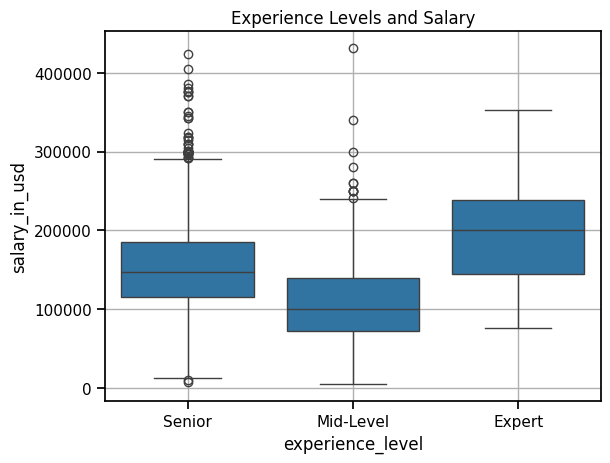

In [134]:
sns.boxplot(x=hypothesis_df.experience_level,y=hypothesis_df.salary_in_usd,data=hypothesis_df).set(title="Experience Levels and Salary")
plt.grid()
plt.show()

In [135]:
formula = 'salary_in_usd ~ C(experience_level)'
model = ols(formula, hypothesis_df).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(experience_level),2.0,1.386587e+12,6.932934e+11,225.667086,2.042699e-92
Residual,3204.0,9.843315e+12,3.072196e+09,NaN,NaN


##### The P-Value is way smaller than the Alpha of 0.05 therefore we reject the null hypothesis and conclude that there is a significant difference in salary in at least one of the three selected experience levels. 

## Next steps in analyzing this data: 

##### It could be valuable to extract insights of the locations with a choropleth map, try some other significance tests, and do some linear regression analysis with scikit-learn to try to determine what the salary of hypothetical future employees would be taking into account their location, work_experience, job_title, and such.

##### I'd like to point out that the data quality was really prime, I chose this dataset because I’d found it interesting, but I had no idea that the Wrangling and Cleaning had so little left to be done, I had a blast diving into the hidden meaning of the data and I love how much Iearned from this course. 